In [1]:
# install necessary packages
!python -m pip install -q dlomix==0.0.4
!python -m pip install -q wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.0 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.2.7 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00


In [18]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import re

import wandb
from wandb.keras import WandbCallback
from wandb.keras import WandbMetricsLogger
import wandb.apis.reports as wr

import dlomix
from dlomix import constants, data, eval, layers, models, pipelines, reports, utils
from dlomix.data import RetentionTimeDataset
from dlomix.models import PrositRetentionTimePredictor
from dlomix.eval import TimeDeltaMetric




In [3]:
# load small train dataset
TRAIN_DATAPATH = 'https://raw.githubusercontent.com/goldjunge3010/masterpraktikum/main/third_pool_tresh_1_0_train.csv'
#TRAIN_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_train_val.csv'
BATCH_SIZE = 64

# create dataset
rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH,
                              seq_length=30, batch_size=BATCH_SIZE, val_ratio=0.2, test=False, sequence_col= "sequence", target_col= "irt")

print(f"Batch size: {rtdata.batch_size}")
print(f"Number training samples : {len(rtdata.train_data) * rtdata.batch_size}")
print(f"Number validation samples : {len(rtdata.val_data) * rtdata.batch_size}")

Batch size: 64
Number training samples : 1088
Number validation samples : 320


In [28]:
# Initialize WANDB
PROJECT = 'matplotlib_workaround'
RUN = "run_2"
wandb.init(project = PROJECT, name = RUN)

# create report
report = wr.Report(project = PROJECT,
                   title = "Retention time report_data",
                   description = "A first try creating a WANDB report using DLOmix")
report.save()

Report(project='matplotlib_workaround', entity='master_praktikum', title='Retention time report_data', description='A first try creating a WANDB report using DLOmix', width='readable')

In [22]:
# function to count sequence length
def count_seq_length(df: pd.DataFrame, seq_col: str) -> pd.Series:
    pattern = re.compile(r"\[UNIMOD:.*\]", re.IGNORECASE)
    df[seq_col].replace(pattern, "", inplace= True)
    return df[seq_col].str.len()


In [23]:
counts = count_seq_length(pd.read_csv(TRAIN_DATAPATH), "sequence")

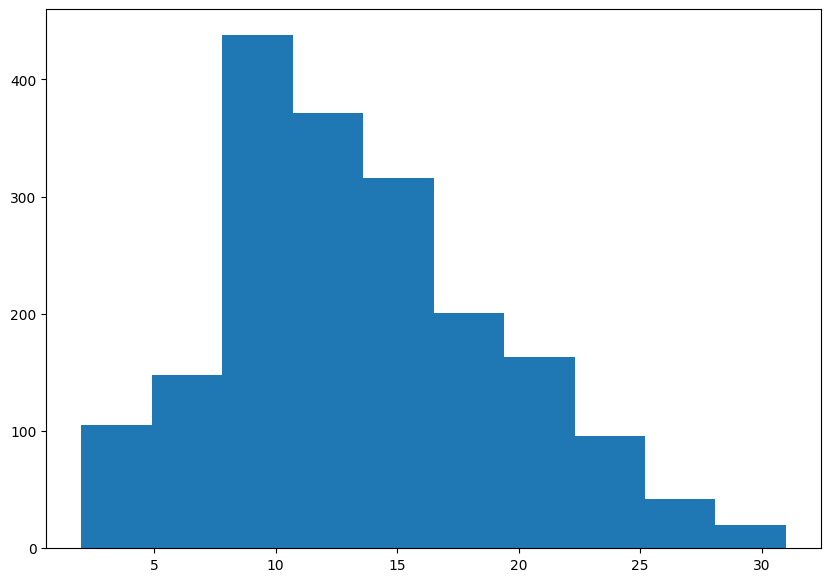

In [44]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(counts)
fig.savefig("histogram2.png")
# Show plot
plt.show()

In [41]:
fig = plt.gcf()
fig.savefig("histogram1.png")

<Figure size 640x480 with 0 Axes>

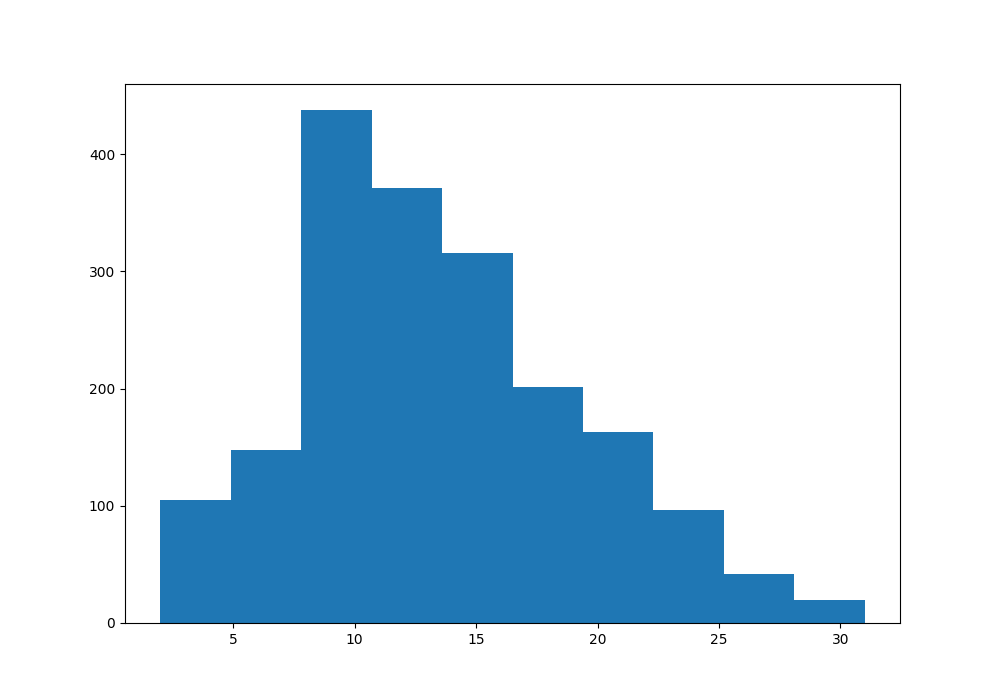

In [47]:
# works but does not really feel & look good

In [46]:
wandb.log({"example": wandb.Image("histogram2.png")})

In [ ]:
# create Prosit retention time predictor
model = PrositRetentionTimePredictor(seq_length=30)

# create the optimizer object
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# compile the model  with the optimizer and the metrics we want to use, we can add our custom timedelta metric
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mean_absolute_error', TimeDeltaMetric()])

In [ ]:
# config the model
config = wandb.config
config.seq_length = 30
config.batch_size = BATCH_SIZE
config.val_ratio = 0.2
config.lr = 0.0001
config.optimizer = "adam"

In [ ]:
# train the model
history = model.fit(rtdata.train_data,
                    validation_data=rtdata.val_data,
                    epochs=2, callbacks=[WandbMetricsLogger(log_freq = "batch")] )
wandb.finish()

Epoch 1/2
17/17 [==============================] - 29s 1s/step - loss: 3546.3992 - mean_absolute_error: 48.9656 - timedelta: 58.5058 - val_loss: 1315.2650 - val_mean_absolute_error: 29.0293 - val_timedelta: 20.3434
Epoch 2/2
17/17 [==============================] - 16s 960ms/step - loss: 3399.5618 - mean_absolute_error: 47.8536 - timedelta: 57.2616 - val_loss: 946.7090 - val_mean_absolute_error: 23.9561 - val_timedelta: 18.6724


batch/batch_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▁▂▂▂▄▄▅▄▄▅▅▆▆▆▇██▁▂▂▂▃▄▅▄▄▅▅▅▆▆▇▇█
batch/mean_absolute_error,▁▂▂▃▄▅▅▅▅▆▆▆▆▇▇██▁▂▂▃▄▅▅▅▅▅▆▆▆▇▇██
batch/timedelta,▁▁▁▃▄▄▅▅▅▆▇▇▇▆▇██▁▁▁▃▄▄▅▅▅▆▇▇▇▆▇▇█
epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/mean_absolute_error,█▁
epoch/timedelta,█▁
epoch/val_loss,█▁


In [ ]:
ENTITY = wandb.apis.PublicApi().default_entity



pg_train = wr.PanelGrid(
    runsets=[
        wr.Runset(ENTITY, PROJECT),
    ],
    panels=[
        wr.LinePlot(x='Step', y=['batch/loss']),
        wr.LinePlot(x='Step', y=['batch/timedelta']),
        wr.LinePlot(x='Step', y=['batch/mean_absolute_error'])
    ]
)

pg_val = wr.PanelGrid(
    runsets=[
        wr.Runset(ENTITY, PROJECT),
    ],
    panels=[
        wr.LinePlot(x='Step', y=['epoch/val_loss']),
        wr.LinePlot(x='Step', y=['epoch/val_timedelta']),
        wr.LinePlot(x='Step', y=['epoch/val_mean_absolute_error'])
    ]
)

report.blocks = report.blocks[:1] +[wr.H1("Training metrics"), pg_train] + [wr.H1("Validation metrics"), pg_val] + report.blocks[1:]

report.save()


Report(project='retention_time_report', entity='master_praktikum', title='Retention time report_data', description='A first try creating a WANDB report using DLOmix', width='readable', blocks=[H1(text=['Training metrics']), PanelGrid(runsets=[Runset(entity='master_praktikum', project='retention_time_report', name='Run set', query='', filters={'$or': [{'$and': []}]}, order=['-CreatedTimestamp'])], panels=[LinePlot(x='Step', y=['batch/loss']), LinePlot(x='Step', y=['batch/timedelta']), LinePlot(x='Step', y=['batch/mean_absolute_error'])]), H1(text=['Validation metrics']), PanelGrid(runsets=[Runset(entity='master_praktikum', project='retention_time_report', name='Run set', query='', filters={'$or': [{'$and': []}]}, order=['-CreatedTimestamp'])], panels=[LinePlot(x='Step', y=['epoch/val_loss']), LinePlot(x='Step', y=['epoch/val_timedelta']), LinePlot(x='Step', y=['epoch/val_mean_absolute_error'])])])

In [ ]:
# Histogramm over peptide lengths

# Histogramm over retention times